loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


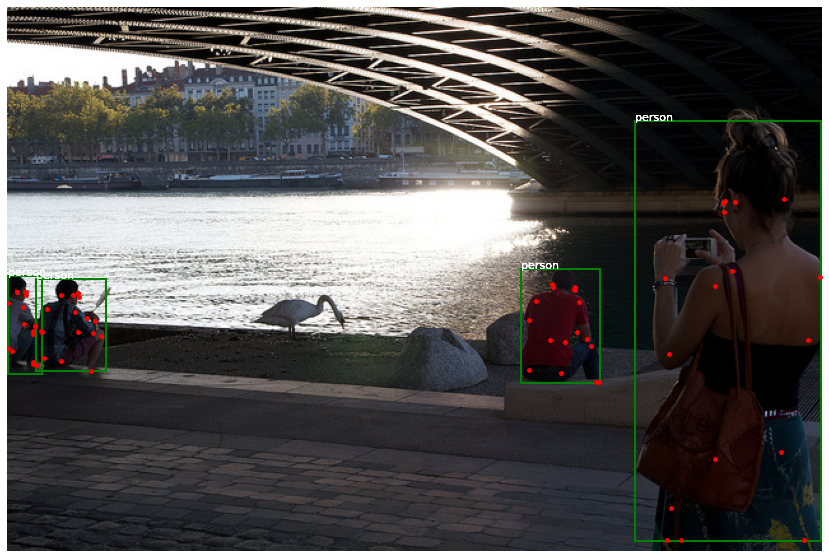



Detected  person  with score:  0.999
Detected  person  with score:  0.998
Detected  person  with score:  0.998
Detected  person  with score:  0.992
(Detected?  person  with score:  0.167)


In [2]:
#First try on Keypoint-Detection using a pre-trained model on the COCO dataset.
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
import torch
import matplotlib.pyplot as plt

#Load the pre-trained model on COCO + resnet50 pre-trained on ImageNet
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True,
                                                   pretrained_backbone=True)

#Download the COCO test dataset
if os.path.isfile("./val2017.zip") == False: 
  !wget "http://images.cocodataset.org/zips/val2017.zip"
  !unzip "./val2017.zip"
  
if os.path.isfile("./annotations_trainval2017.zip") == False:  
  !wget "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
  !unzip "./annotations_trainval2017.zip"

#Import the test images of the dataset
cocoDataset = datasets.CocoDetection(root="./val2017", 
                                     annFile="./annotations/instances_val2017.json",
                                     transform=transforms.ToTensor())

def showImageFromDataset(imageNumber):
  #Take only the image tensor from the dataset
  imgTensor = cocoDataset[imageNumber][0]

  #Tensor -> PIL image transformation
  transToPIL = transforms.ToPILImage(mode='RGB')
  imgPIL = transToPIL(imgTensor.squeeze())

  #Show the image
  plt.imshow(imgPIL)
  plt.show()

def showImageWithDetection(imageNumber, modelOutput, threshold):

  #Take only the image tensor from the dataset
  imgTensor = cocoDataset[imageNumber][0]

  #Tensor -> PIL image transformation
  transToPIL = transforms.ToPILImage(mode='RGB')
  imgPIL = transToPIL(imgTensor.squeeze())

  #Extract the targets values from the list of tensors
  boxes  = [d['boxes']  for d in modelOutput]
  labels = [d['labels'] for d in modelOutput]
  scores = [d['scores'] for d in modelOutput]  
  keypoints = [d['keypoints'] for d in modelOutput]  
  
  #print(torch.numel(boxes[0])/4) #Just to check
  
  #Output classes of the COCO dataset
  COCO_CATEGORY_NAMES = [ 
  'background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
  'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
  'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
  'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
  'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
  'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
  'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
  'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
  'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
  'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
  'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
  'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
  ]

  #Show the image with the bounding boxes (rectangles)
  plt.figure(figsize=(20,10))
  plt.imshow(imgPIL)
  plt.axis("off")

  numBoxes = int(torch.numel(boxes[0])/4)

  for i in range(numBoxes):
    #Apply a threshold to the score in order to have less but better predictions
    for i in range(torch.numel(scores[0])): #numel(scores[0])=numel(labels[0])=numel(boxes[0])/4
      if scores[0][i] > threshold:
        rect = plt.Rectangle((boxes[0][i][0], boxes[0][i][1]),
                              boxes[0][i][2] - boxes[0][i][0],
                              boxes[0][i][3] - boxes[0][i][1], fill=False,
                              edgecolor="g", linewidth=2)
        plt.gca().add_patch(rect)

        #Add the category of the detected
        plt.gca().text(boxes[0][i][0], boxes[0][i][1],COCO_CATEGORY_NAMES[labels[0][i]],
                      color='white',fontsize=11)
        
        #Add the detected keypoints (v=visibility=on) in each bounding box
        x_list = [x for [x, y, v] in keypoints[0][i]]
        y_list = [y for [x, y, v] in keypoints[0][i]]

        plt.plot(x_list, y_list,'ro',markersize=3)
          
  plt.show()

  #Print the accuracy for each prediction 
  print('\n') 
  for i in range(numBoxes):
    obj = COCO_CATEGORY_NAMES[labels[0][i]]

    #Apply a threshold to distinguish between certain and less good detections
    if scores[0][i] > threshold:      
      print('{:s} {:s} {:s} {:.3f}'.format('Detected ', obj, ' with score: ',scores[0][i]))
    else:
      print('{:s} {:s} {:s} {:.3f}{:s}'.format('(Detected? ', obj, ' with score: ',scores[0][i],')'))


def testModel(model, imageNumber, device):
  model.eval()

  with torch.no_grad(): #Without computing the gradients (just testing)

    imgTensor = cocoDataset[imageNumber][0]    
    imgTensor = imgTensor.to(device)
        
    output = model(imgTensor.unsqueeze_(0)) #Model output   
    #print(output) #Just to check  

  return output

#Select one image from the COCO testing dataset
imageToTest = 10

#Show the "raw" image
#showImageFromDataset(imageToTest) 

#Call the testModel function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output = testModel(model, imageToTest, device)

#Show the results given the image and the model output
threshold = 0.5 #Set a minimum value of the certainty about the prediction
showImageWithDetection(imageToTest,output,threshold)


In [3]:
#Select several images from the COCO testing dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for imageToTest in range(17,25):
  #Call the testModel function  
  output = testModel(model, imageToTest, device) 
  #Set a minimum value % of the prediction certainty
  threshold = 0.5 
  #Show the results
  showImageWithDetection(imageToTest,output,threshold) 

Output hidden; open in https://colab.research.google.com to view.